In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch.nn.functional as F
import altair as alt
from torch.utils.tensorboard import SummaryWriter
import torchvision

In [49]:
# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

In [50]:
# Import the data
train_dataset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.ToTensor()
)
test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.ToTensor()
)

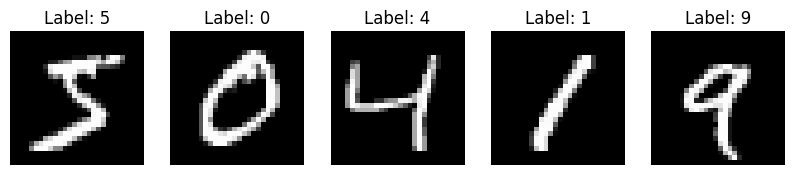

In [51]:
# Use this block to show images for the data and familiarize myself with the data
# Load MNIST without transforming to tensors
train_dataset_pic = datasets.MNIST(root="./data", train=True, download=True)

# Display 5 images
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i, ax in enumerate(axes):
    image, label = train_dataset_pic[i]  # Get image and label
    ax.imshow(image, cmap="gray")
    ax.set_title(f"Label: {label}")
    ax.axis("off")
plt.show()

In [52]:
# Transformations
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

# make the data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [53]:
# init the nn class with an init function and a forward pass
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(
            28 * 28, 512
        )  # Input: 28x28 image, Hidden layer: 512 neurons
        self.fc2 = nn.Linear(512, 10)  # Output: 10 classes (digits 0-9)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the image
        x = F.relu(self.fc1(x))  # what should this be if F is wrong?
        x = self.fc2(x)
        return x

In [54]:
model = torchvision.models.resnet50(False)
# Have ResNet model take in grayscale rather than RGB
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
images, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(images)
writer.add_image("images", grid, 0)
writer.add_graph(model, images)
writer.close()

c:\Users\Domenick Dobbs\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\Domenick Dobbs\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [55]:
# establish the model, loss function and the optim (brett used Adam so lets go with that one. the list is insanely long to choose from)
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [56]:
# Initialize lists to store metrics - gonna use this for graphing my learning
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [57]:
# Training loop
for epoch in range(10):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss = loss.item()
        train_losses.append(train_loss)

        _, predicted = torch.max(
            output.data, 1
        )  # the underscore is our throwaway variable which is apprently a common naming convention -COOL!
        train_accuracy = (predicted == target).sum().item() / len(train_dataset) * 100
        train_accuracies.append(train_accuracy)

    # the song says "print out whats happenin'"
    print(f"Epoch {epoch}: Loss: {loss.item():.4f}")

Epoch 0: Loss: 0.0577
Epoch 1: Loss: 0.0255
Epoch 2: Loss: 0.1031
Epoch 3: Loss: 0.0039
Epoch 4: Loss: 0.0490
Epoch 5: Loss: 0.0057
Epoch 6: Loss: 0.0082
Epoch 7: Loss: 0.0398
Epoch 8: Loss: 0.0194
Epoch 9: Loss: 0.0104


In [58]:
model.eval()  # Set the model to evaluation mode
test_loss = 0
correct = 0
with torch.no_grad():  # No gradients needed during evaluation
    for data, target in test_loader:
        output = model(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)  # for display
        accuracy = 100.0 * correct / len(test_loader.dataset)
        test_accuracies.append(accuracy)  # for display


print(f"Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")

Test Loss: 0.0000, Accuracy: 97.99%


In [59]:
train_losses = train_losses[:10]
train_accuracies = train_accuracies[:10]
test_losses = test_losses[:10]
test_accuracies = test_accuracies[:10]
print(train_losses)
print(train_accuracies)
print(test_losses)
print(test_accuracies)

[2.3304529190063477, 2.210047960281372, 2.1490020751953125, 2.0895156860351562, 2.049038887023926, 1.8435338735580444, 1.8443201780319214, 1.7978209257125854, 1.6973177194595337, 1.4846094846725464]
[0.006666666666666667, 0.045, 0.045, 0.043333333333333335, 0.05, 0.065, 0.06333333333333332, 0.055, 0.06333333333333332, 0.08166666666666667]
[2.0654523745179177e-06, 2.37393414253369e-06, 2.1476405665628855e-06, 1.1907176860747787e-05, 7.289618937113462e-07, 1.6603217899508157e-05, 1.6152394534527964e-06, 1.814897204763903e-06, 2.4097871324373555e-07, 8.312286692571184e-06]
[0.63, 1.26, 1.89, 2.52, 3.16, 3.78, 4.41, 5.05, 5.69, 6.31]


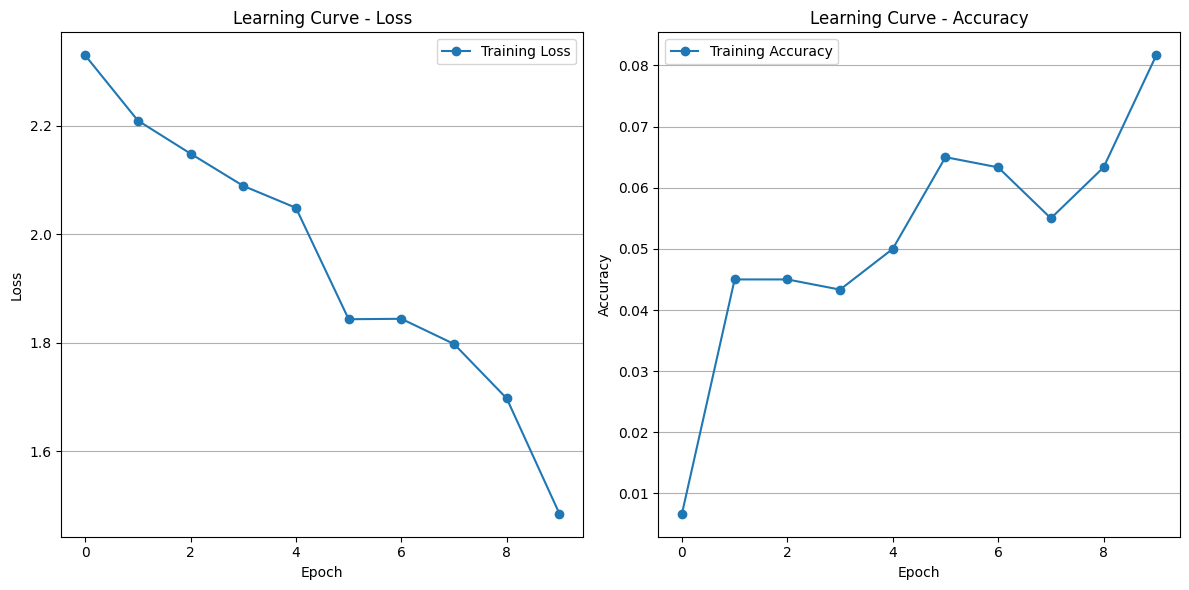

In [60]:
epochs = range(10)
# Plotting
plt.figure(figsize=(12, 6))

# Loss Chart
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Training Loss", marker="o")
# plt.plot(epochs, test_losses, label='Epoch', marker='x')
plt.title("Learning Curve - Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(axis="y")

# Accuracy Chart
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Training Accuracy", marker="o")
# plt.plot(epochs, test_accuracies, label='Epoch', marker='x')
plt.title("Learning Curve - Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(axis="y")

plt.tight_layout()
plt.show()

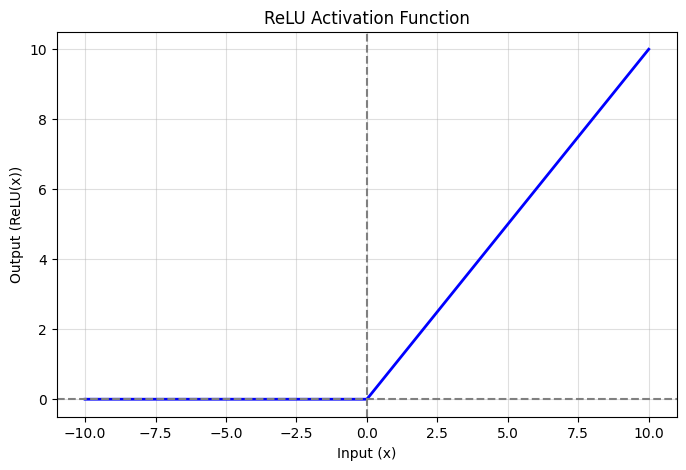

In [61]:
# Create input values
x = np.linspace(-10, 10, 400)  # Range from -10 to 10 with 400 points for smoothness

# Calculate ReLU output
y = np.maximum(0, x)

# Plotting
plt.figure(figsize=(8, 5))  # Optional: Set figure size
plt.plot(x, y, color="blue", linewidth=2)
plt.title("ReLU Activation Function")
plt.xlabel("Input (x)")
plt.ylabel("Output (ReLU(x))")
plt.axhline(0, color="gray", linestyle="dashed")  # Dashed line at y=0
plt.axvline(0, color="gray", linestyle="dashed")  # Dashed line at x=0
plt.grid(alpha=0.4)  # Add a light grid
plt.show()

In [62]:
%tensorboard --logdir logs/fit

UsageError: Line magic function `%tensorboard` not found.


In [ ]:
# Run tensorboard with
# tensorboard --logdir=runs